# Evaluation of model trained at 40x on other magnification levels

In [1]:
import os
import gc
import torch
import wandb
import pickle
from PIL import Image
from transformers import AutoModel
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import roc_auc_score
from torch import nn
from tqdm import tqdm
from PathBinaryClassifier import PathBinaryClassifier

In [2]:
# Making datasets
def loader(path):
    img = Image.open(path)
    return img

transform = v2.Compose(
    [
        v2.Resize(224),
        v2.CenterCrop(224),
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]
)

dataset_40 = ImageFolder(
    '../images/40X/', 
    loader=loader,
    transform=transform
)

dataset_100 = ImageFolder(
    '../images/100X/', 
    loader=loader,
    transform=transform
)
dataset_200 = ImageFolder(
    '../images/200X/', 
    loader=loader,
    transform=transform
)
dataset_400 = ImageFolder(
    '../images/400X/', 
    loader=loader,
    transform=transform
)

# Make dataloaders
test_dataloader_40 = DataLoader(dataset_40, batch_size=32, shuffle=False, num_workers=4)
test_dataloader_100 = DataLoader(dataset_100, batch_size=32, shuffle=False, num_workers=4)
test_dataloader_200 = DataLoader(dataset_200, batch_size=32, shuffle=False, num_workers=4)
test_dataloader_400 = DataLoader(dataset_400, batch_size=32, shuffle=False, num_workers=4)

In [3]:
# Load model from fine-tuning run on 40x images

# Load backbone
with torch.no_grad():
    backbone = AutoModel.from_pretrained('kaiko-ai/midnight')

# Load config
with open('model_configs/best_hp_3bh8rw9f.pickle', 'rb') as f:
    config = pickle.load(f)

dropout = config['dropout']
hidden = config['classifier_hidden_dim']

model = PathBinaryClassifier(backbone, hidden=hidden, dropout=dropout)

In [4]:
state_dict = torch.load('models/PathBinaryClassifier_fine-tuning-experiment-0.pt')

model.load_state_dict(state_dict)
model

PathBinaryClassifier(
  (backbone): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-39): 40 x Dinov2Layer(
          (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=1536, out_features=1536, bias=True)
              (key): Linear(in_features=1536, out_features=1536, bias=True)
              (value): Linear(in_features=1536, out_features=1536, bias=True)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=1536, out_features=1536, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (layer_scale1): Dinov2

In [5]:
# Put model on GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    model.to(device)

In [6]:
def test(model, test_dataloader):
    """
    Evaluates trained model on test set and logs results to Wandb
    """
    running_correct = 0
    y_true = []
    y_score = []
    
    # Evaluating on test dataset
    model.eval() # ensure model is in evaluation mode
    with torch.no_grad():
        for X, y in tqdm(test_dataloader):
            X, y, = X.to(device), y.to(device)
    
            # Get predictions
            output = model(X)
            
            # Count correct predictions
            preds = torch.argmax(output, dim=1)
            running_correct += sum(preds == y).item()

            # For later AUROC computation
            y_probs = torch.softmax(output, dim=1)[:, 1] # Get probabilities of positive class
            y_score.extend(y_probs.cpu().numpy())
            y_true.extend(y.cpu().numpy())


    # Metrics for validation epoch
    test_acc = running_correct / len(test_dataloader.dataset)
    test_auroc = roc_auc_score(y_true, y_score)
                                            
    print(f'---- Test Accuracy: {test_acc} ----')
    print(f'---- Test AUROC: {test_auroc} ----')
    
    return test_acc, test_auroc

# Re-Testing Model on 40X Magnification to get AUROC

In [8]:
test_acc_40, test_auroc_40 = test(model, test_dataloader_40)
test_acc_40, test_auroc_40

100%|███████████████████████████████████████████| 63/63 [05:25<00:00,  5.17s/it]

---- Test Accuracy: 0.6882205513784461 ----
---- Test AUROC: 0.8011532846715329 ----


(0.6882205513784461, 0.8011532846715329)

# Testing Model on 100x Magnification

In [9]:
test_acc_100, test_auroc_100 = test(model, test_dataloader_100)
test_acc_100, test_auroc_100

100%|███████████████████████████████████████████| 66/66 [05:39<00:00,  5.15s/it]

---- Test Accuracy: 0.6929360884190293 ----
---- Test AUROC: 0.5247793453407505 ----


(0.6929360884190293, 0.5247793453407505)

# Testing Model on 200x Magnification

In [10]:
test_acc_200, test_auroc_200 = test(model, test_dataloader_200)
test_acc_200, test_auroc_200

100%|███████████████████████████████████████████| 63/63 [05:28<00:00,  5.21s/it]

---- Test Accuracy: 0.6920019870839543 ----
---- Test AUROC: 0.5025058604801552 ----


(0.6920019870839543, 0.5025058604801552)

# Testing Model on 400x Magnification

In [11]:
test_acc_400, test_auroc_400 = test(model, test_dataloader_400)
test_acc_400, test_auroc_400

100%|███████████████████████████████████████████| 57/57 [04:57<00:00,  5.21s/it]

---- Test Accuracy: 0.6785714285714286 ----
---- Test AUROC: 0.6261512721971905 ----


(0.6785714285714286, 0.6261512721971905)

# Sanity Check: Testing randomly initialized model without fine-tuning on 40X dataset (Fine-tuned accuracy was 0.70333)

In [12]:
# Clear space in GPU
del model
gc.collect()
torch.cuda.empty_cache()

# Load backbone
with torch.no_grad():
    backbone = AutoModel.from_pretrained('kaiko-ai/midnight')

# Load config
with open('model_configs/best_hp_3bh8rw9f.pickle', 'rb') as f:
    config = pickle.load(f)

dropout = config['dropout']
hidden = config['classifier_hidden_dim']

model = PathBinaryClassifier(backbone, hidden=hidden, dropout=dropout).to(device)

test_acc_40_no_tuning, test_auroc_40_no_tuning = test(model, test_dataloader_40)
test_acc_40_no_tuning, test_auroc_40_no_tuning

100%|███████████████████████████████████████████| 63/63 [05:25<00:00,  5.17s/it]

---- Test Accuracy: 0.5543859649122806 ----
---- Test AUROC: 0.6248426277372263 ----


(0.5543859649122806, 0.6248426277372263)

# Sanity Check: Ensuring images at different magnification levels actually look like they are at different magnification levels

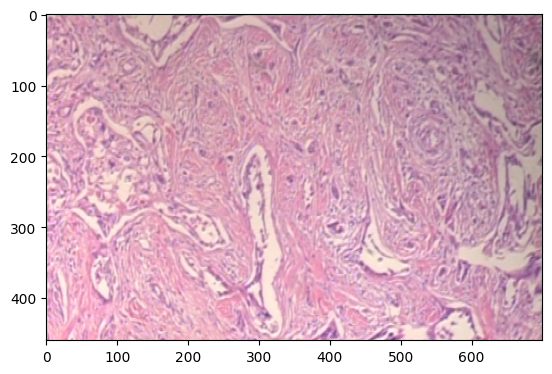

In [14]:
import matplotlib.pyplot as plt
# 40X
img_40X = Image.open('../images/40X/malignant/ductal_carcinoma/SOB_M_DC-14-10926-40-001.png')
plt.imshow(img_40X)

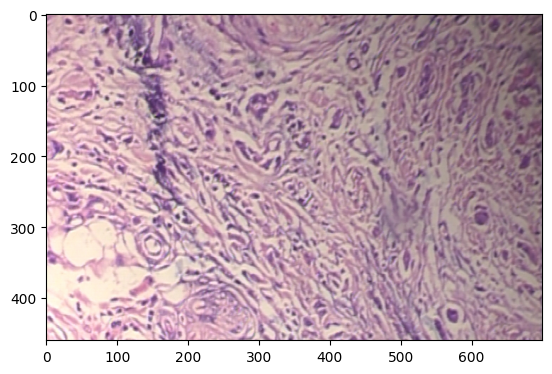

In [15]:
# 100X
img_100X = Image.open('../images/100X/malignant/ductal_carcinoma/SOB_M_DC-14-10926-100-001.png')
plt.imshow(img_100X)

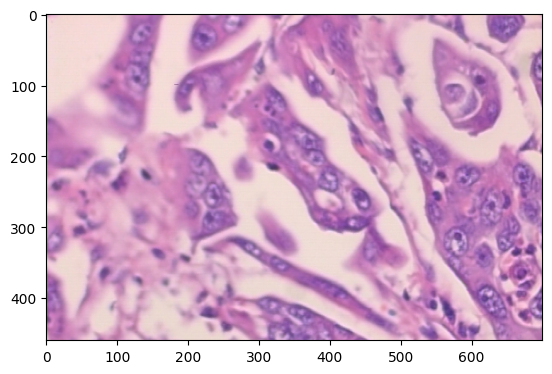

In [16]:
# 200X
img_200X = Image.open('../images/200X/malignant/ductal_carcinoma/SOB_M_DC-14-10926-200-001.png')
plt.imshow(img_200X)

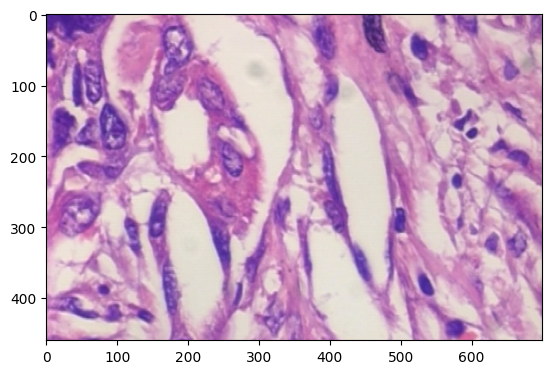

In [17]:
# 400X
img_400X = Image.open('../images/400X/malignant/ductal_carcinoma/SOB_M_DC-14-10926-400-001.png')
plt.imshow(img_400X)

# Plotting Results

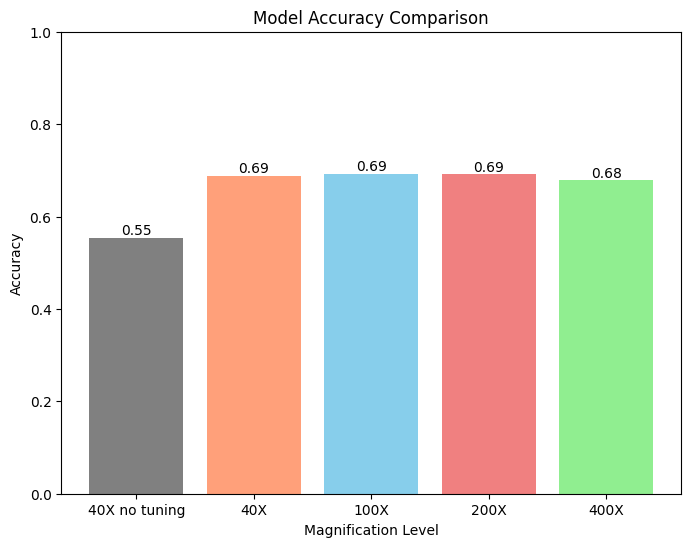

In [18]:
# Plotting Accuracies

mag_levels = ['40X no tuning', '40X', '100X', '200X', '400X']

accuracies = [test_acc_40_no_tuning, test_acc_40, test_acc_100, test_acc_200, test_acc_400]

# Create the bar plot
plt.figure(figsize=(8, 6)) # Optional: Adjust figure size for better readability
plt.bar(mag_levels, accuracies, color=['grey', 'lightsalmon', 'skyblue', 'lightcoral', 'lightgreen'])

# Add labels and title
plt.xlabel('Magnification Level')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1) # Set y-axis limits from 0 to 1 for accuracy

# Optional: Add accuracy values on top of the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy, f'{accuracy:.2f}', ha='center', va='bottom')

# Display the plot
plt.show()

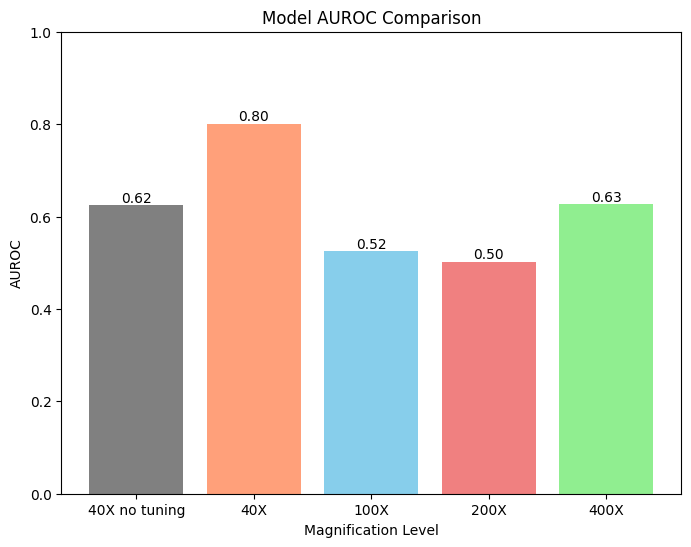

In [19]:
# Plotting AUROCs
aurocs = [test_auroc_40_no_tuning, test_auroc_40, test_auroc_100, test_auroc_200, test_auroc_400]

# Create the bar plot
plt.figure(figsize=(8, 6)) # Optional: Adjust figure size for better readability
plt.bar(mag_levels, aurocs, color=['grey', 'lightsalmon', 'skyblue', 'lightcoral', 'lightgreen'])

# Add labels and title
plt.xlabel('Magnification Level')
plt.ylabel('AUROC')
plt.title('Model AUROC Comparison')
plt.ylim(0, 1) # Set y-axis limits from 0 to 1 for accuracy

# Optional: Add accuracy values on top of the bars
for i, auroc in enumerate(aurocs):
    plt.text(i, auroc, f'{auroc:.2f}', ha='center', va='bottom')

# Display the plot
plt.show()